In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
deepp = deep_properties()

## TESTING LISTS WITH NP.ARRAYS

In [2]:
# Example 2D array size!
shape = (2, 2)
deep_id = np.random.randint(1, 12, size=shape)  # Adjust range based on deep_id count
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# Flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# Function to return NumPy arrays inside a NumPy array
def get_layered_data(deep_id_f, key, deepp, is_pF=False):
    """Returns a NumPy array where each entry is a NumPy array of variable length.
    
    If `is_pF=True`, it skips NumPy conversion (since pF is a dictionary).
    """
    deep_id_map = {v['deep_id']: v[key] if is_pF else np.array(v[key], dtype=float) for v in deepp.values()}
    return np.array([deep_id_map.get(d_id, {} if is_pF else np.array([], dtype=float)) for d_id in deep_id_f], dtype=object)

# Assigning values (NumPy arrays inside NumPy array)
deep_zs = get_layered_data(deep_id_f, 'deep_z', deepp)
deep_ksats = get_layered_data(deep_id_f, 'deep_ksat', deepp)
deep_pFs = get_layered_data(deep_id_f, 'pF', deepp, is_pF=True)  # Do not convert to NumPy array yet

# Handling pF parameters separately, ensuring NumPy arrays
def extract_pF_param(deep_pFs, param):
    """Extracts specific pF parameter and ensures NumPy array conversion."""
    return np.array([np.array(v[param], dtype=float) if isinstance(v, dict) else np.array([], dtype=float) for v in deep_pFs], dtype=object)

deep_ThetaS = extract_pF_param(deep_pFs, 'ThetaS')
deep_ThetaR = extract_pF_param(deep_pFs, 'ThetaR')
deep_n = extract_pF_param(deep_pFs, 'n')
deep_alpha = extract_pF_param(deep_pFs, 'alpha')

In [17]:
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [array([ -0.5,  -2.5, -13. ]) array([ -1.2,  -3.8,  -4. , -14.4, -16. ])
 array([ -0.8,  -3. , -14. ]) array([ -0.5,  -2.5, -13. ])]
deep_pFs [{'ThetaS': [0.43, 0.43, 0.43], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}
 {'ThetaS': [0.43, 0.43, 0.43], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}]
deep_ksats [array([2.e-06, 2.e-06, 1.e-06])
 array([1.e-07, 3.e-05, 1.e-08, 3.e-05, 1.e-04])
 array([3.e-05, 1.e-08, 1.e-06]) array([2.e-06, 2.e-06, 1.e-06])]


## 2D NP.ARRAYS

In [7]:
# INITIALIZING
max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (2, 2)
deep_id = np.random.randint(1, 4, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# below if pFs need to separated to each param
#deep_ThetaS = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_ThetaR = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_n = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_alpha = np.full((len(deep_id_f), max_nlyrs), np.nan)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        #deep_ThetaS[mask, :nlyrs] = value['pF']['ThetaS']
        #deep_ThetaR[mask, :nlyrs] = value['pF']['ThetaR']
        #deep_n[mask, :nlyrs] = value['pF']['n']
        #deep_alpha[mask, :nlyrs] = value['pF']['alpha']
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']

In [3]:
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [[-24.  nan  nan  nan  nan]
 [ -5.  -7. -21.  nan  nan]
 [-29.  nan  nan  nan  nan]
 [-26.  nan  nan  nan  nan]]
deep_pFs [{'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}
 {'ThetaS': [0.89, 0.89, 0.89], 'ThetaR': [0.196, 0.196, 0.196], 'alpha': [0.072, 0.072, 0.072], 'n': [1.255, 1.255, 1.255]}
 {'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}
 {'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}]
deep_ksats [[1.e-04    nan    nan    nan    nan]
 [1.e-06 1.e-09 1.e-06    nan    nan]
 [1.e-04    nan    nan    nan    nan]
 [1.e-04    nan    nan    nan    nan]]


## NOW TRYING TO VECTORIZE!

### ATTEMPTING TO VECTORIZE THESE FUNCTIONS BELOW :)

In [209]:

def gwl_Wsto(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        - pF (np.ndarrays):
            - dict
                - 'ThetaS' saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'ThetaR' residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'alpha' air entry suction [cm\ :sup:`-1`]
                - 'n' pore size distribution [-]
        - z (np.ndarrays): soil compartment thichness, node in center [m]
    Returns:
        - (np.ndarray):
            - dict
                - 'to_gwl': interpolated function for gwl(Wsto)
                - 'to_wsto': interpolated function for Wsto(gwl)
                - 'to_C'
                - 'to_Tr'
    """
    dz = abs(z)
    dz[:,1:] = z[:,:-1] - z[:,1:]
    step = -0.01
    #step = -0.05
    z_min = np.nanmin(z, axis=1)
    max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
    z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
    ix = np.full((z_fine.shape), np.nan)
    # Expand z along the second axis to match z_fine's shape (broadcasting)
    z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
    z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

    # Compute mask using broadcasting (row-wise comparison)
    mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

    # Sum along the depth dimension to count how many times z_fine falls below z
    ix = np.sum(mask, axis=2).astype(np.float64)  # Convert to float to retain NaN compatibility

    pF_fine = {}

    for key in pF[0].keys():  # Iterate over each parameter in `pF`
        # Convert pF into an array ensuring consistent shapes
        try:
            pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
        except ValueError:  # If rows have different lengths, handle it gracefully
            max_depth = max(len(p[key]) for p in pF)  # Find the longest row
            pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

            # Fill rows with actual values
            for i, p in enumerate(pF):
                pF_array[i, :len(p[key])] = p[key]

        # Ensure `ix` values are within valid range (clip to prevent indexing errors)
        ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

        # Assign values using vectorized indexing
        pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

    # --------- connection between gwl and Wsto, Tr, C------------
    
    z_min = np.nanmin(z, axis=1)
    #z_min_min = np.nanmin(z)
    #gwl = np.arange(1.0, z_min - 5, step)
    #gwl = np.vectorize(lambda z: np.arange(1, z - 5, step) if not np.isnan(z) else np.array([]), otypes=[object])(z_min_min)
    #gwl = np.array(gwl)
    
    # Find the global minimum of z_min, ignoring NaNs
    z_min_min = np.nanmin(z_min)
    # Create the common gwl range
    # step
    #common_gwl = np.arange(1, z_min_min - 5, step)
    common_gwl = np.linspace(1, z_min_min, max_len)

    #max_len = len(common_gwl)
    # Preallocate a 2D array with NaNs
    gwl = np.full((z_min.size, max_len), np.nan)
    # Fill each row with the common gwl values if z_min is not NaN
    valid_mask = ~np.isnan(z_min)
    gwl[valid_mask, :] = common_gwl
   
    Wsto_deep = h_to_cellmoist_vectorized(pF_fine, gwl, z_mid_fine)

    #Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
    #        + max(0.0, g) for g in gwl]

    #if root:
    #    Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]
    #    Wsto_deep = Wsto_deep/sum(dz)
    #    GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
    #    return {'to_rootmoist': GwlToWsto}

    # solve transmissivity corresponding to gwls
    #Tr = [transmissivity(dz, Ksat, g) * 86400. for g in gwl]  # [m2 d-1]

    Tr = transmissivity_vectorized(dz, Ksat, gwl) * 86400

    WstoToGwl = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(Wsto_deep, gwl)]
    GwlToWsto = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(gwl, Wsto_deep)]
    GwlToC = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(gwl, np.gradient(Wsto_deep, axis=1)/np.gradient(gwl, axis=1))]
    GwlToTr = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(gwl, Tr)]

    #WstoToGwl = interp1d(np.array(Wsto_deep), np.array(gwl_2), fill_value='extrapolate')
    #GwlToWsto = interp1d(np.array(gwl_2), np.array(Wsto_deep), fill_value='extrapolate')
    #GwlToC = interp1d(np.array(gwl), np.array(np.gradient(Wsto_deep)/np.gradient(gwl)), fill_value='extrapolate')
    #GwlToTr = interp1d(np.array(gwl), np.array(Tr), fill_value='extrapolate')
    
    #plt.figure(1)
    #plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep/np.gradient(gwl))))
    #plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr)))
    #plt.plot(np.array(gwl), np.array(Tr))
    #plt.figure(3)
    #plt.plot(np.array(gwl), np.array(Wsto_deep))
    #return gwl
    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC, 'to_Tr': GwlToTr}

def h_to_cellmoist(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' (array): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' (array): air entry suction [cm\ :sup:`-1`]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]

    Kersti Haahti, Luke 8/1/2018
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)
    print('ix', ix)

    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def h_to_cellmoist_vectorized(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' (array): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' (array): air entry suction [cm\ :sup:`-1`]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]

    Kersti Haahti, Luke 8/1/2018
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    # THIS IS PROBABLY IT GOES WRONG!
    ix = np.where(abs(h) < dz/2)
    print('ix[0]', ix[0])

    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def transmissivity(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer.

    Args:
       dz (array):  soil compartment thickness, node in center [m]
       Ksat (array): horizontal saturated hydr. cond. [ms-1]
       gwl (float): ground water level below surface, <0 [m]

    Returns:
       Qz_drain (array): drainage from each soil layer [m3 m-3 s-1]
    """
    z = dz / 2 - np.cumsum(dz)
    Tr = 0.0

    ib = sum(dz)

    # depth of saturated layer above impermeable bottom
    # Hdr = min(max(0, gwl + ib), ib)  # old
    Hdr = max(0, gwl + ib)  # not restricted to soil profile -> transmissivity increases when gwl above ground surface level

    """ drainage from saturated layers above ditch base """
    # layers above ditch bottom where drainage is possible
    ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

    if Hdr > 0:
        # saturated layer thickness [m]
        dz_sat = np.maximum(gwl - (z - dz / 2), 0)
        # transmissivity of layers  [m2 s-1]
        Trans = Ksat * dz_sat

        """ drainage from saturated layers above ditch base """
        # layers above ditch bottom where drainage is possible
        ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

        if ix.size > 0:
            dz_sat[ix[-1]] = dz_sat[ix[-1]] + (z[ix][-1] - dz[ix][-1] / 2 + ib)
            Trans[ix[-1]] = Ksat[ix[-1]] * dz_sat[ix[-1]]
            Tr = sum(Trans[ix])
        
    if Tr < 1e-16:
        #Tr[Tr < 1e-16] = 1e-4
        Tr = 1e-4 / 86400

    return Tr


def transmissivity_vectorized(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer for 2D inputs.

    Args:
       dz (2D array):  Soil compartment thickness, node in center [m] (shape: (n_cells, n_layers))
       Ksat (2D array): Horizontal saturated hydraulic conductivity [m/s] (shape: (n_cells, n_layers))
       gwl (2D array): Groundwater level below surface, <0 [m] (shape: (n_cells, n_gwl))

    Returns:
       Tr (2D array): Transmissivity for each cell and groundwater level [m²/s] (shape: (n_cells, n_gwl))
    """

    # Compute z (midpoints of layers)
    axis = 1  # Operate along layers
    z = dz / 2 - np.cumsum(dz, axis=axis)  # Shape: (n_cells, n_layers)

    # Compute total thickness of soil profile (impermeable boundary depth)
    ib = np.sum(dz, axis=axis, keepdims=True)  # Shape: (n_cells, 1), keeps dimension for broadcasting

    # Compute saturated layer thickness (Hdr)
    Hdr = np.maximum(0, gwl + ib)  # Shape: (n_cells, n_gwl)

    # Create mask to find layers contributing to drainage
    mask = ((z - dz / 2)[:, :, None] - gwl[:, None, :] < 0) & ((z + dz / 2)[:, :, None] > -ib[:, None, :])
    
    # Compute saturated thickness for each layer
    dz_sat = np.maximum(gwl[:, None, :] - (z - dz / 2)[:, :, None], 0)  # Shape: (n_cells, n_layers, n_gwl)

    # Compute transmissivity of each layer
    Trans = Ksat[:, :, None] * dz_sat  # Shape: (n_cells, n_layers, n_gwl)

    # Find last contributing layer index for each (cell, gwl)
    ix = np.argmax(mask[:, ::-1, :], axis=1)  # Index within reversed layers
    ix = mask.shape[1] - 1 - ix  # Convert to correct layer index

    # Construct a mask to select valid indices
    valid_mask = np.any(mask, axis=1)  # Shape: (n_cells, n_gwl), True where any layer contributes

    # Adjust last layer's saturated thickness
    row_idx, gwl_idx = np.where(valid_mask)  # Get (cell, gwl) index pairs
    last_layer_idx = ix[row_idx, gwl_idx]  # Get last contributing layer indices

    dz_sat[row_idx, last_layer_idx, gwl_idx] += (
        z[row_idx, last_layer_idx] - dz[row_idx, last_layer_idx] / 2 + ib[row_idx, 0]
    )

    # Recalculate Trans after modifying dz_sat
    Trans[row_idx, last_layer_idx, gwl_idx] = Ksat[row_idx, last_layer_idx] * dz_sat[row_idx, last_layer_idx, gwl_idx]

    # Sum transmissivity across valid layers
    Tr = np.where(valid_mask, np.sum(Trans * mask, axis=1), 1e-4 / 86400)  # Shape: (n_cells, n_gwl)

    return Tr  # Shape: (n_cells, n_gwl)


In [203]:
z = deep_zs[0]
pF = deep_pFs[0]
gwl = np.arange(1, -30, -0.05)
###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine= (np.arange(0, min(z), -0.01) - 0.01).astype(np.float64)
dz_fine = z_fine*0.0 + 0.01
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)
print(dz_fine)

###
z = deep_zs
pF = deep_pFs
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
step = -0.01
#step = -0.05
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine*0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
print(dz_fine[0])

[0.01 0.01 0.01 ... 0.01 0.01 0.01]
[0.01 0.01 0.01 ... 0.01 0.01 0.01]


### TESTING H_TO_CELL_MOIST SEPARATELY

ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([], dtype=int64),)
ix (array([0]),)
ix (array([5]),)
ix (array([10]),)
ix (array([15]),)
ix (array([20]),)
ix (array([25]),)
ix (array([30]),)
ix (array([35]),)
ix (array([40]),)
ix (array([45]),)
ix (array([50]),)
ix (array([55]),)
ix (array([60]),)
ix (array([65]),)
ix (array([70]),)
ix (array([75]),)
ix (array([80]),)
ix (array([85]),)
ix (array([90]),)
ix (array([95]),)
ix (array([100]),)
ix (array([105]),)
ix (array([110]),)
ix (a

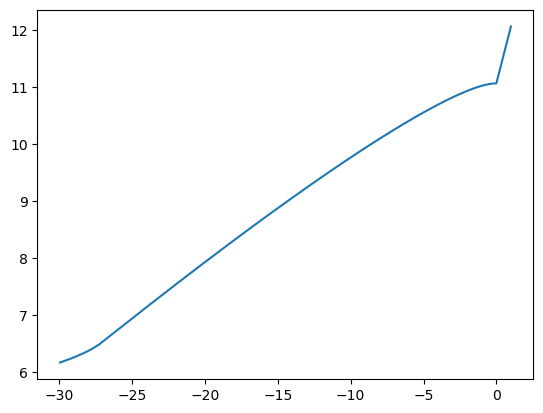

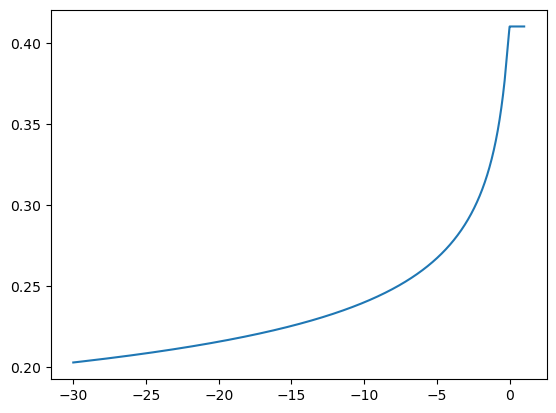

In [210]:
z = deep_zs[0]
pF = deep_pFs[0]
gwl = np.arange(1, -30, -0.05)
###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine= (np.arange(0, min(z), -0.01) - 0.01).astype(np.float64)
dz_fine = z_fine*0.0 + 0.01
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)

ix = np.zeros(len(z_fine), dtype=np.float64)

for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})

Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]
plt.figure(1)
plt.plot(np.array(gwl), np.array(Wsto_deep))

###
z = deep_zs
pF = deep_pFs
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
step = -0.01
#step = -0.05
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine*0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(np.float64)  # Convert to float to retain NaN compatibility

pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

# --------- connection between gwl and Wsto, Tr, C------------

z_min = np.nanmin(z, axis=1)

# Find the global minimum of z_min, ignoring NaNs
z_min_min = np.nanmin(z_min)
common_gwl = np.linspace(1, z_min_min, max_len)
# Preallocate a 2D array with NaNs
gwl = np.full((z_min.size, max_len), np.nan)
# Fill each row with the common gwl values if z_min is not NaN
valid_mask = ~np.isnan(z_min)
gwl[valid_mask, :] = common_gwl

Wsto_deep = h_to_cellmoist_vectorized(pF_fine, gwl, dz_fine)

plt.figure(2)
plt.plot(np.array(gwl[0]), np.array(Wsto_deep[0]))

### TESTING TRANSMISSIVITY SEPARATELY

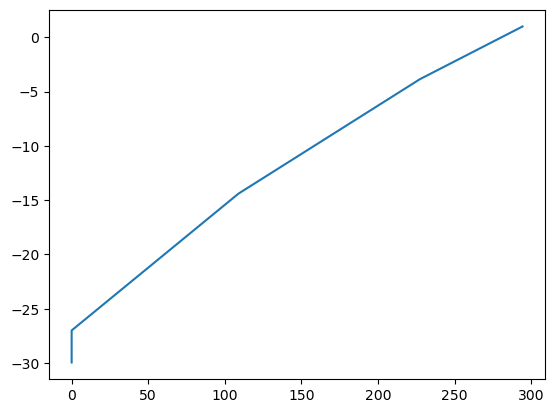

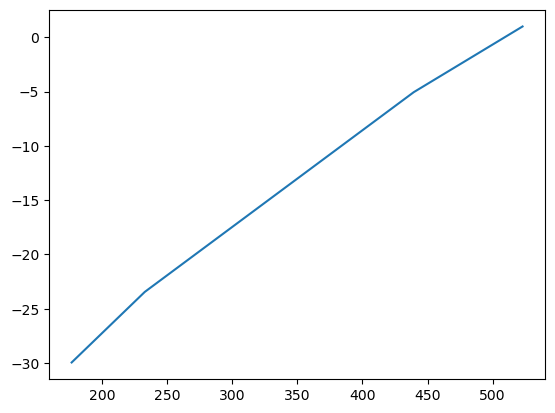

In [177]:
gwl = np.arange(1, -30, -0.05)
z = deep_zs[0]
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

Tr0 = [transmissivity(dz, deep_ksats[0], g) * 86400. for g in gwl]  # [m2 d-1]
plt.figure(1)
plt.plot(Tr0, gwl)

gwl = np.arange(1, -30, -0.05).reshape(1, -1)
z = deep_zs
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

Tr1 = transmissivity_vectorized(dz, deep_ksats, gwl) * 86400
plt.figure(2)
plt.plot(Tr1[0], gwl[0])

In [156]:
ifs = gwl_Wsto(deep_zs, deep_pFs, deep_ksats)
wtso_to_gwl = ifs['to_gwl']

In [165]:
wtso_to_gwl[0](0.001)

array(-229.03540855)

## THIS IS WITHOUT VECTORIZATION, FOR LOOPS

In [1]:
from soilprofile2D import gwl_Wsto as gwl_Wsto_old
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
deepp = deep_properties()

max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (100, 100)
deep_id = np.random.randint(1, 4, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# below if pFs need to separated to each param
#deep_ThetaS = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_ThetaR = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_n = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_alpha = np.full((len(deep_id_f), max_nlyrs), np.nan)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        #deep_ThetaS[mask, :nlyrs] = value['pF']['ThetaS']
        #deep_ThetaR[mask, :nlyrs] = value['pF']['ThetaR']
        #deep_n[mask, :nlyrs] = value['pF']['n']
        #deep_alpha[mask, :nlyrs] = value['pF']['alpha']
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']

In [144]:
deep_zs

array([[ -1.2,  -3.8,  -4. , -14.4, -27. ],
       [ -5. ,  -7. , -28. ,   nan,   nan],
       [-24. ,   nan,   nan,   nan,   nan],
       ...,
       [-26. ,   nan,   nan,   nan,   nan],
       [ -1.2,  -3.8,  -4. , -14.4, -21. ],
       [-21. ,   nan,   nan,   nan,   nan]])

In [145]:
ifs = gwl_Wsto_old(deep_zs[0], deep_pFs[0], deep_ksats[0])

dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  -9.2 -20.7]
ix [0 1 2 3 4]
dz [ 1.2  2.6  0.2 10.4 12.6]
z [ -0.6  -2.5  -3.9  

In [149]:
ifs['to_gwl'](100)

array(88.93)

In [5]:
for i in range(len(deep_id_f)):
    if isinstance(deep_pFs[i], dict):  # Ensure it's valid before calling gwl_Wsto
        deep_ifs[i] = gwl_Wsto_old(deep_zs[i], deep_pFs[i], deep_ksats[i])
        deep_ifs_root[i] = gwl_Wsto_old(deep_zs[i][:2], 
                                    {k: deep_pFs[i][k][:2] for k in deep_pFs[i]}, 
                                    root=True)

        wtso_to_gwl[i] = deep_ifs[i]['to_gwl']
        gwl_to_wsto[i] = deep_ifs[i]['to_wsto']
        gwl_to_C[i] = deep_ifs[i]['to_C']
        gwl_to_Tr[i] = deep_ifs[i]['to_Tr']
        gwl_to_rootmoist[i] = deep_ifs_root[i]['to_rootmoist']

wtso_to_gwl = wtso_to_gwl.reshape(deep_id.shape)
gwl_to_wsto = gwl_to_wsto.reshape(deep_id.shape)
gwl_to_C = gwl_to_C.reshape(deep_id.shape)
gwl_to_Tr = gwl_to_Tr.reshape(deep_id.shape)
gwl_to_rootmoist = gwl_to_rootmoist.reshape(deep_id.shape)

In [10]:
ifs

{'to_gwl': <scipy.interpolate._interpolate.interp1d at 0x16a7e0050>,
 'to_wsto': <scipy.interpolate._interpolate.interp1d at 0x16a413a20>,
 'to_C': <scipy.interpolate._interpolate.interp1d at 0x16a4122b0>,
 'to_Tr': <scipy.interpolate._interpolate.interp1d at 0x103699860>}

In [66]:
# testing interpolation functions
gwl =  np.linspace(-1, -20, num=3000)
Wsto = np.linspace(50, 80, num=3000)

x_new = np.linspace(52, 80, num=10000)  # New x-values

In [67]:
ys = interp1d(Wsto, gwl, fill_value='extrapolate')

In [68]:
ys(x_new)

array([ -2.26666667,  -2.26844018,  -2.27021369, ..., -19.99645298,
       -19.99822649, -20.        ])

In [69]:
np.interp(x_new, Wsto, gwl)

array([ -2.26666667,  -2.26844018,  -2.27021369, ..., -19.99645298,
       -19.99822649, -20.        ])

In [32]:
ys(10)

array(39.611389)

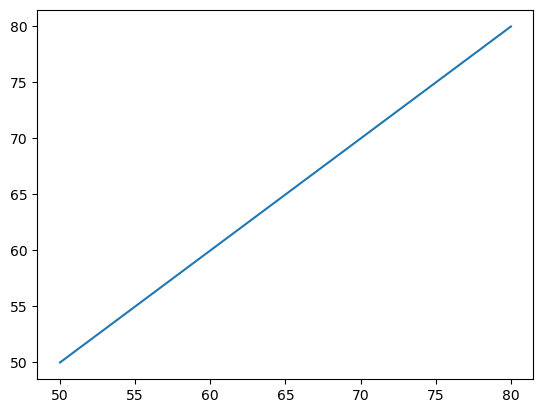

In [35]:
plt.plot(Wsto, Wsto)